In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
import xgboost
from sklearn.ensemble import RandomForestRegressor 
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate

In [2]:
os.chdir(r"C:\Users\Roozbeh\Vehicular Data\London")

In [3]:
df = pd.read_csv('AA_LONDON_DATA_VER3_DATA_TABLE.csv')

In [4]:
camdf = pd.read_csv('AA_LONDON_CAMERA_DATA_TABLE.csv')

In [5]:
df[:2]

,S_NO,CAMERA_NAME,DOWNLOAD_DATE,IMG_NAME,DENSITY_VALUE,DL_TIMESTAMP_LOCAL,COMMENTS,CAMERA_ID,DL_TIMESTAMP_CITY,SELECT_FLAG,RED,GREEN,BLUE
0,896208,549744,22-NOV-10,1290433594,16109.680,22-NOV-10 02.46.34.000000000 PM,NaN,182,22-NOV-10 01.46.34.000000000 PM,1,63621.507812,65366.414062,64108.488281
1,896209,549744,22-NOV-10,1290434044,11318.897,22-NOV-10 02.54.04.000000000 PM,NaN,182,22-NOV-10 01.54.04.000000000 PM,1,64379.992188,66520.500000,65209.515625


In [6]:
camdf[:2]

,CAMERA_ID,CAMERA_NAME,CAMERA_DESC,EASTING,NORTHING,GEO_LAT,GEO_LON,CONGESTION_ZONE
0,105,546600,A4 Cromwell Road by Earls Court Road,525351.39,178843.06,51.494572,-0.195707,0
1,106,546610,A4 Great West Road By Macbeth Street,522781.00,178369.00,51.490875,-0.232884,0


In [ ]:
mergedf = df.merge(camdf,left_on="CAMERA_ID",right_on="CAMERA_ID")

tdf = mergedf[["CAMERA_ID","GEO_LON","GEO_LAT","DL_TIMESTAMP_CITY","DENSITY_VALUE"]].copy()

tdf['TIMESTAMP']  = pd.to_datetime(tdf['DL_TIMESTAMP_CITY'],format="%d-%b-%y %I.%M.%S.000000000 %p")

try:
    tdf.drop("DL_TIMESTAMP_CITY",axis=1,inplace=True)
except:
    print("column doesn't exist")

In [11]:
tdf[:2]

,CAMERA_ID,GEO_LON,GEO_LAT,DENSITY_VALUE,TIMESTAMP
0,182,-0.245122,51.616876,16109.680,2010-11-22 13:46:34
1,182,-0.245122,51.616876,11318.897,2010-11-22 13:54:04


In [12]:
from sklearn.preprocessing import minmax_scale,StandardScaler

In [13]:
tdf_scaled = tdf.copy()
tdf_scaled["TIME_EPOCH"] = (tdf_scaled.TIMESTAMP.astype(np.int64) // 10**9)
tdf_scaled.drop("TIMESTAMP",axis=1,inplace=True)

In [14]:
Xscaler = StandardScaler()
yscaler = StandardScaler()

In [15]:
features = ["GEO_LON","GEO_LAT","TIME_EPOCH"]
target = "DENSITY_VALUE"

In [16]:
Xscaler.fit(tdf_scaled[features])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [17]:
tdf_scaled.loc[:,features] = Xscaler.transform(tdf_scaled[features])

In [18]:
tdf_scaled[:2]

,CAMERA_ID,GEO_LON,GEO_LAT,DENSITY_VALUE,TIME_EPOCH
0,182,-1.04219,0.093388,16109.680,1.687794
1,182,-1.04219,0.093388,11318.897,1.688208


(array([6.29430e+04, 1.65024e+05, 2.02636e+05, 1.81667e+05, 1.34736e+05,
        8.71730e+04, 4.43660e+04, 1.51770e+04, 2.34500e+03, 1.79000e+02]),
 array([5.25718650e+01, 6.46663178e+03, 1.28806917e+04, 1.92947516e+04,
        2.57088115e+04, 3.21228714e+04, 3.85369313e+04, 4.49509913e+04,
        5.13650512e+04, 5.77791111e+04, 6.41931710e+04]),
 <a list of 10 Patch objects>)

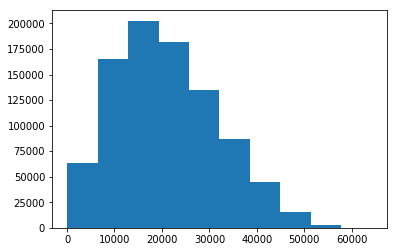

In [19]:
plt.hist(tdf_scaled.DENSITY_VALUE)

In [20]:
yscaler.fit(tdf_scaled["DENSITY_VALUE"].values.reshape((-1,1)))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [21]:
tdf_scaled.loc[:,"DENSITY_VALUE"] = yscaler.transform(tdf_scaled["DENSITY_VALUE"].values.reshape((-1,1)))

In [22]:
tdf_scaled[:5]

,CAMERA_ID,GEO_LON,GEO_LAT,DENSITY_VALUE,TIME_EPOCH
0,182,-1.04219,0.093388,-0.459432,1.687794
1,182,-1.04219,0.093388,-0.906670,1.688208
2,182,-1.04219,0.093388,-0.936942,1.689285
3,182,-1.04219,0.093388,-0.296766,1.689865
4,182,-1.04219,0.093388,-0.976171,1.690197


(array([6.29430e+04, 1.65024e+05, 2.02636e+05, 1.81667e+05, 1.34736e+05,
        8.71730e+04, 4.43660e+04, 1.51770e+04, 2.34500e+03, 1.79000e+02]),
 array([-1.95842481, -1.35964772, -0.76087064, -0.16209355,  0.43668353,
         1.03546062,  1.63423771,  2.23301479,  2.83179188,  3.43056896,
         4.02934605]),
 <a list of 10 Patch objects>)

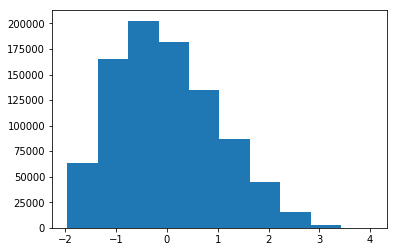

In [23]:
plt.hist(tdf_scaled.DENSITY_VALUE)

Let's get train test split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(tdf_scaled[features],tdf_scaled[target],shuffle=True,random_state=12345)

In [26]:
rfreg = RandomForestRegressor(n_jobs = -1,n_estimators = 100)

In [29]:
mses = []
r2s = []
kf = KFold(n_splits=4,shuffle=True)
for train_index, test_index in kf.split(tdf_scaled):
    rfreg = RandomForestRegressor(n_jobs = -1,n_estimators = 100)
    rfreg.fit(tdf_scaled.loc[train_index,features],tdf_scaled.loc[train_index,target])
    r2s.append(rfreg.score(tdf_scaled.loc[test_index,features],tdf_scaled.loc[test_index,target]))
    mses.append(mean_squared_error(tdf_scaled.loc[test_index,target],rfreg.predict(tdf_scaled.loc[test_index,features])))

In [30]:
np.sqrt(mses),r2s

(array([0.33661578, 0.33737287, 0.33920894, 0.33947866]),
 [0.887231470089923,
  0.8860222055117317,
  0.8851654235781107,
  0.8841271658676231])

In [ ]:
rfreg = RandomForestRegressor(n_jobs = -1,n_estimators = 100)

In [ ]:
rf_res = cross_validate(rfreg,tdf_scaled[features],tdf_scaled[target],scoring=["r2","rmse"],cv=4,n_jobs=-1,return_train_score=True)

In [ ]:
rf_res

Let's try knn-r from scikit

In [31]:
knreg = KNeighborsRegressor(n_jobs=-1,weights = "distance")

In [ ]:
knr_res = cross_validate(knreg,tdf_scaled[features],tdf_scaled[target],scoring=["r2","mean_squared_error"],cv=4,n_jobs=-1,return_train_score=True)

In [ ]:
knr_res

In [32]:
knr_mses = []
knr_r2s = []
kf = KFold(n_splits=4,shuffle=True)
for train_index, test_index in kf.split(tdf_scaled):
    knreg = KNeighborsRegressor(n_jobs=-1,weights = "distance")
    knreg.fit(tdf_scaled.loc[train_index,features],tdf_scaled.loc[train_index,target])
    knr_r2s.append(knreg.score(tdf_scaled.loc[test_index,features],tdf_scaled.loc[test_index,target]))
    knr_mses.append(mean_squared_error(tdf_scaled.loc[test_index,target],knreg.predict(tdf_scaled.loc[test_index,features])))

In [33]:
np.sqrt(knr_mses)

array([0.33786062, 0.33438946, 0.33524828, 0.33364744])

In [34]:
knr_r2s

[0.885354384498201, 0.8882433577311021, 0.88751251111103, 0.8891926827897271]

### Trying holding out some cameras when testing (number of cameras are very limited so as x,y coordinates)

In [35]:
knr_mses = []
knr_r2s = []
for i in range(10):
    test_cameras = np.random.choice(tdf_scaled.CAMERA_ID.unique(),size=15)

    df_train = tdf_scaled[~tdf_scaled.CAMERA_ID.isin(test_cameras)]
    df_test = tdf_scaled[tdf_scaled.CAMERA_ID.isin(test_cameras)]

    knreg = KNeighborsRegressor(n_jobs=-1,weights = "distance")
    knreg.fit(df_train[features],df_train[target])
    knr_r2s.append(knreg.score(df_test[features],df_test[target]))
    knr_mses.append(mean_squared_error(df_test[target],knreg.predict(df_test[features])))

In [68]:
np.sqrt(knr_mses),np.mean(np.sqrt(knr_mses)),knr_r2s

(array([0.90048179, 1.02264185, 0.96393434, 1.1097555 , 1.06587156,
        1.00703832, 0.91425884, 0.99387183, 1.05439011, 0.98068451]),
 1.001292864381655,
 [0.20535412362454442,
  -0.030487350206272575,
  0.024182720401401125,
  -0.23817319343501353,
  -0.2961429324548055,
  -0.0408205599885092,
  0.13332966655165257,
  -0.059212532247634016,
  0.0098967014404292,
  -0.19749056425548317])

In [37]:
rf_mses = []
rf_r2s = []
for i in range(5):
    test_cameras = np.random.choice(tdf_scaled.CAMERA_ID.unique(),size=15)

    df_train = tdf_scaled[~tdf_scaled.CAMERA_ID.isin(test_cameras)]
    df_test = tdf_scaled[tdf_scaled.CAMERA_ID.isin(test_cameras)]

    rfreg = RandomForestRegressor(n_jobs = -1,n_estimators = 100)
    rfreg.fit(df_train[features],df_train[target])
    rf_r2s.append(rfreg.score(df_test[features],df_test[target]))
    rf_mses.append(mean_squared_error(df_test[target],rfreg.predict(df_test[features])))

In [69]:
np.sqrt(rf_mses),np.mean(np.sqrt(rf_mses)),rf_r2s

(array([0.8605844 , 0.84358207, 1.01978436, 0.97863077, 0.98420934]),
 0.937358191073969,
 [0.32766385079534355,
  0.3236101718992287,
  -0.043316586668658674,
  0.08461416570799263,
  0.05736835102493254])

### Let's try forecast part

In [53]:
tdf_scaled.sort_values(["TIME_EPOCH"],inplace=True)

In [49]:
from sklearn.model_selection import TimeSeriesSplit

In [50]:
tscv = TimeSeriesSplit(n_splits=4)

In [54]:
knr_r2s_forecast = []
knr_mses_forecast = []
for train_index, test_index in tscv.split(tdf_scaled):
    knreg = KNeighborsRegressor(n_jobs=-1,weights = "distance")
    knreg.fit(tdf_scaled.loc[train_index,features],tdf_scaled.loc[train_index,target])
    knr_r2s_forecast.append(knreg.score(tdf_scaled.loc[test_index,features],tdf_scaled.loc[test_index,target]))
    knr_mses_forecast.append(mean_squared_error(tdf_scaled.loc[test_index,target],knreg.predict(tdf_scaled.loc[test_index,features])))

In [64]:
np.sqrt(knr_mses_forecast),np.mean(np.sqrt(knr_mses_forecast))

(array([1.05168212, 0.99561216, 1.10547723, 1.00613269]), 1.0397260510781883)

In [57]:
knr_r2s_forecast

[-0.21500719725637252,
 0.0017321373742889001,
 -0.1699272791718951,
 0.07865351640299723]

In [58]:
rf_r2s_forecast = []
rf_mses_forecast = []
for train_index, test_index in tscv.split(tdf_scaled):
    rfreg = RandomForestRegressor(n_jobs = -1,n_estimators = 100)
    rfreg.fit(tdf_scaled.loc[train_index,features],tdf_scaled.loc[train_index,target])
    rf_r2s_forecast.append(rfreg.score(tdf_scaled.loc[test_index,features],tdf_scaled.loc[test_index,target]))
    rf_mses_forecast.append(mean_squared_error(tdf_scaled.loc[test_index,target],rfreg.predict(tdf_scaled.loc[test_index,features])))

In [65]:
np.sqrt(rf_mses_forecast),np.mean(np.sqrt(rf_mses_forecast))

(array([0.98698865, 1.01478231, 1.08543041, 0.99089357]), 1.019523735695623)

In [60]:
rf_r2s_forecast

[-0.07012419081738508,
 -0.03708053287956825,
 -0.1278808704558847,
 0.10635199582926147]

In [61]:
xgb_r2s_forecast = []
xgb_mses_forecast = []
for train_index, test_index in tscv.split(tdf_scaled):
    xgbreg = xgb.XGBRegressor(n_jobs=-1,num_rounds = 250)
    xgbreg.fit(tdf_scaled.loc[train_index,features],tdf_scaled.loc[train_index,target])
    xgb_r2s_forecast.append(xgbreg.score(tdf_scaled.loc[test_index,features],tdf_scaled.loc[test_index,target]))
    xgb_mses_forecast.append(mean_squared_error(tdf_scaled.loc[test_index,target],xgbreg.predict(tdf_scaled.loc[test_index,features])))

In [66]:
np.sqrt(xgb_mses_forecast),np.mean(np.sqrt(xgb_mses_forecast))

(array([0.94074077, 0.91209494, 1.02932626, 0.97877771]), 0.9652349182161343)

In [63]:
xgb_r2s_forecast

[0.027813027205506047,
 0.16218757792275285,
 -0.014297523351051389,
 0.12807203676891132]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tdf_scaled[features], tdf_scaled[target], test_size=0.2, random_state=123)

In [ ]:
dtrain = xgb.DMatrix(X_train,y_train)
dtest = xgb.DMatrix(X_test,y_test)

In [ ]:
xgbreg = xgb.XGBRegressor(n_jobs=-1)

In [41]:
xgb_mses = []
xgb_r2s = []
kf = KFold(n_splits=4,shuffle=True)
for train_index, test_index in kf.split(tdf_scaled):
    xgbreg = xgb.XGBRegressor(n_jobs=-1,num_rounds=250)
    xgbreg.fit(tdf_scaled.loc[train_index,features],tdf_scaled.loc[train_index,target])
    xgb_r2s.append(xgbreg.score(tdf_scaled.loc[test_index,features],tdf_scaled.loc[test_index,target]))
    xgb_mses.append(mean_squared_error(tdf_scaled.loc[test_index,target],xgbreg.predict(tdf_scaled.loc[test_index,features])))

In [42]:
np.sqrt(xgb_mses),xgb_r2s

(array([0.83247154, 0.83315695, 0.8343967 , 0.83248735]),
 [0.30685556743335174,
  0.3023608155234251,
  0.30797234685553915,
  0.3063429619055199])

In [70]:
xgb_mses = []
xgb_r2s = []
for i in range(5):
    test_cameras = np.random.choice(tdf_scaled.CAMERA_ID.unique(),size=15)

    df_train = tdf_scaled[~tdf_scaled.CAMERA_ID.isin(test_cameras)]
    df_test = tdf_scaled[tdf_scaled.CAMERA_ID.isin(test_cameras)]

    xgbreg = xgb.XGBRegressor(n_jobs=-1,num_rounds = 200)
    xgbreg.fit(df_train[features],df_train[target])
    xgb_r2s.append(xgbreg.score(df_test[features],df_test[target]))
    xgb_mses.append(mean_squared_error(df_test[target],xgbreg.predict(df_test[features])))

In [71]:
np.sqrt(xgb_mses),np.mean(np.sqrt(xgb_mses))

(array([0.83487645, 0.82168749, 0.87428683, 0.9120464 , 0.93251724]),
 0.8750828812868484)

In [45]:
xgb_r2s

[0.25402999559830897,
 0.24897232363445043,
 0.10824006688631582,
 0.2456396096929738,
 0.16751012038318913]

In [ ]:
dtrain = xgb.DMatrix(tdf_scaled[features],label=tdf_scaled[target])
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,'max_depth': 5, 'alpha': 10}
cv_results = xgb.cv(params=params,dtrain=dtrain, nfold=5,num_boost_round=200,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [ ]:
cv_results

In [ ]:
cv_results["test-rmse-mean"].plot()

In [ ]:
cam_groups = tdf.groupby("CAMERA_ID")

In [ ]:
tdf["SCALED_DENSITY"] = preprocessing.scale(tdf["DENSITY_VALUE"])

In [ ]:
tdf["SCALED01percamera_DENSITY"] = 1

In [ ]:
for cam_id, cam_df in cam_groups:
    tdf.loc[tdf["CAMERA_ID"] == cam_id,"SCALED01percamera_DENSITY"] = minmax_scale(cam_df["DENSITY"])

In [ ]:
tdf["TIME_EPOCH"] = tdf.TIMESTAMP.astype(np.int64) // 10**9

In [ ]:
tdf[:2]

In [ ]:
tdf.to_parquet()